# grizzlies - Stlr features
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 27 # grizzlies
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(6328, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6328 entries, 0 to 6327
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            6328 non-null   int64  
 1   dimCustomerMasterId     6328 non-null   int64  
 2   customerNumber          6328 non-null   object 
 3   year                    6328 non-null   int64  
 4   productGrouping         6328 non-null   object 
 5   totalSpent              6328 non-null   float64
 6   recentDate              6328 non-null   object 
 7   attendancePercent       6328 non-null   float64
 8   renewedBeforeDays       6292 non-null   float64
 9   isBuyer                 6328 non-null   object 
 10  source_tenure           6328 non-null   int64  
 11  tenure                  6292 non-null   float64
 12  distToVenue             6328 non-null   float64
 13  totalGames              6328 non-null   int64  
 14  recency                 6328 non-null   

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
                "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (4859, 13)
Unseen Data For Predictions: (858, 13)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.6944,0.7606,0.7437,0.7135,0.7280,0.3797,0.3806,0.3400
lr,Logistic Regression,0.6707,0.7272,0.6614,0.7178,0.6883,0.3405,0.3419,0.2870


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7046,0.7743,0.7325,0.7325,0.7325,0.4027,0.4027
1,0.6973,0.7603,0.7181,0.7277,0.7228,0.3895,0.3896
2,0.6804,0.7505,0.7709,0.6863,0.7261,0.3455,0.3489
3,0.7215,0.7842,0.7489,0.7456,0.7473,0.4373,0.4373
4,0.6925,0.7686,0.7357,0.7137,0.7245,0.3767,0.3770
5,0.6901,0.7435,0.7313,0.7124,0.7217,0.3721,0.3723
6,0.6780,0.7519,0.7048,0.7080,0.7064,0.3498,0.3498
7,0.6998,0.7727,0.7753,0.7068,0.7395,0.3870,0.3893
8,0.6877,0.7472,0.7577,0.6992,0.7273,0.3632,0.3648
9,0.6925,0.7529,0.7621,0.7033,0.7315,0.3731,0.3747


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [11]:
df_inference = df.loc[df["year"] >= 2020]
df_inference = df_inference.fillna(0)
df_inference.shape

(611, 54)

In [12]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
5717,27,323074094,325825,2020,Half Season,1656.0,1970-01-01,0.0,96.0,TRUE,...,0,0,0.0,1,78,0,0,0,0.9017,0.0983
5718,27,323074161,535900,2020,Half Season,3637.2,1970-01-01,0.0,48.0,TRUE,...,0,0,0.0,1,78,0,0,0,0.9219,0.0781
5719,27,323074257,535347,2020,Full Season,910.0,1970-01-01,0.0,53.0,TRUE,...,0,0,0.0,1,78,0,0,0,0.9650,0.0350
5720,27,323074446,320356,2020,Full Season,1575.0,1970-01-01,0.0,90.0,TRUE,...,0,0,0.0,1,78,0,0,0,0.8719,0.1281
5721,27,323075109,317372,2020,Half Season,1050.0,1970-01-01,0.0,50.0,TRUE,...,0,0,0.0,1,78,0,0,0,0.9460,0.0540


In [13]:
new_predictions["Label"].value_counts()

0    587
1     24
Name: Label, dtype: int64

In [14]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    402
(0.2, 0.4]       147
(0.4, 0.6]        50
(0.6, 0.8]         9
(0.8, 1.0]         3
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

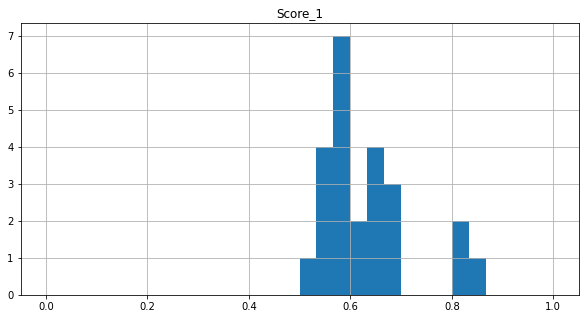

In [15]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

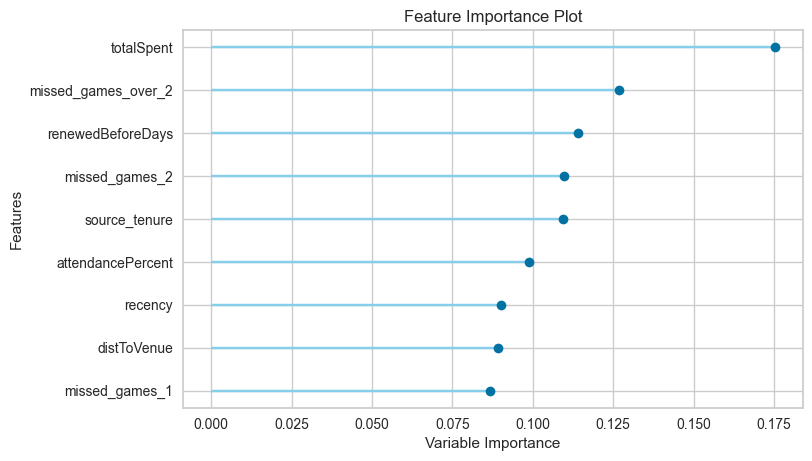

In [16]:
plot_model(best_model, plot='feature')

In [ ]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?